## Single flight analysis and plots

In [2]:
# imports from packages
#import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # gridspec for nested subfigures
import matplotlib.dates as mdates
from matplotlib.patches import Patch # for legend handle
from matplotlib.lines import Line2D  # for legend handle
#import seaborn as sns
#import warnings
import cartopy.crs as ccrs
import cartopy.feature as creature

# imports from files
from numb_conc import *
import read_nav


In [3]:
# --- Global formatting/settings/variables

# -- formatting for showing time, but not date, on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

# -- Skipping cells in jupyter notebook, to skip a cell put %%skip at the top of the cell
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return
    
# --- Thresholds for in-cloud values
# ----- Water content threshold
# following the korolev 22 paper: "In the present study the thresholds for liquid water content and ice water content (IWC) 
# were set as LWC > 0.01 g m−3, IWC > 0.01 g m−3, respectively. The phase composition of clouds was identified based on the 
# assessment of the ice water fraction mu = IWC∕(LWC + IWC). Thus, clouds with mu=0.9 were considered as ice, 
# clouds with Mu =0.1 were defined as liquid, 
# and clouds 0.1 ≤ 𝜇𝜇 ≤ 0.9 were determined as mixed-phase clouds."
lwc_th = 0.01

# ----- Number concentration threshold
# Following table 2 from Evans et al 2025:
# Ice concentration threshold to define ice = 0.1 L-1 (or m-3) (NT100 is given in m-3)
# Cdp drop concentration to define liquid = 2 cm-3 (numb conc corrected is given in cm-3)

n_ice_th = 0.1
n_drp_th = 2

In [4]:
# --- Selections
flight = 'IS22-02'
sample_rate = 1

In [5]:
# --- Data import

# Import the processed data:

main_path = '/home/ninalar/Documents/MC2/Results_2022-islas/Processed/ISLAS_processed' 
file = f'/microphy_{sample_rate}s_{flight}.nc' # structure of cip text-file names

print(main_path+file)

flight_ds = xr.open_mfdataset(main_path+file, combine='by_coords', combine_attrs='drop_conflicts')

'''
# import the satellite data:
folder = "sea_ice_satellite/" # for example
ds = xr.open_dataset(folder + "MOD021KM.A2022088.1135.nc")
ds_i = ds.isel(time=0) # Choose the first time 
'''

/home/ninalar/Documents/MC2/Results_2022-islas/Processed/ISLAS_processed/microphy_1s_IS22-02.nc


'\n# import the satellite data:\nfolder = "sea_ice_satellite/" # for example\nds = xr.open_dataset(folder + "MOD021KM.A2022088.1135.nc")\nds_i = ds.isel(time=0) # Choose the first time \n'

In [6]:
# for checking simple files
#file = '/home/ninalar/Documents/MC2/Results_2022-islas/1sAveraging/as220007/no_allin/microphy_1s_IS22-02.nc' # structure of cip text-file names
#flight='IS22-02-no_allin-'

#file = '/home/ninalar/Documents/MC2/Results_2022-islas/1sAveraging/as220007/no_allin_or_shatter/microphy_1s_IS22-02.nc' # structure of cip text-file names
#flight='IS22-02-no_allin_or_shatter-'

file = '/home/ninalar/Documents/MC2/Results_2022-islas/1sAveraging/as220007/No_shattercorrect/microphy_1s_IS22-02.nc' # structure of cip text-file names
flight='IS22-02-no_shatter-'

print(file)

flight_ds = xr.open_mfdataset(file, combine='by_coords', combine_attrs='drop_conflicts')

sample_rate='1'

/home/ninalar/Documents/MC2/Results_2022-islas/1sAveraging/as220007/No_shattercorrect/microphy_1s_IS22-02.nc


OSError: no files to open

In [7]:
max_value = flight_ds['IWC100'].max()
#mask = (flight_ds['IWC100'] == max_value).compute()
mask = (flight_ds['IWC100']>1).compute()
flight_ds.time.where(mask, drop = True)

<xarray.DataArray 'time' (time: 13)> Size: 104B
array(['2022-03-22T11:46:48.000000000', '2022-03-22T12:34:29.000000000',
       '2022-03-22T12:34:30.000000000', '2022-03-22T12:35:16.000000000',
       '2022-03-22T12:35:18.000000000', '2022-03-22T12:35:19.000000000',
       '2022-03-22T12:35:20.000000000', '2022-03-22T12:35:22.000000000',
       '2022-03-22T12:35:23.000000000', '2022-03-22T12:35:24.000000000',
       '2022-03-22T12:35:25.000000000', '2022-03-22T13:43:46.000000000',
       '2022-03-22T13:45:09.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 104B 2022-03-22T11:46:48 ... 2022-03-22T13...
    lat      (time) float32 52B 70.66 71.14 71.14 71.1 ... 71.09 72.82 72.75
    lon      (time) float32 52B 20.21 21.37 21.37 21.35 ... 21.35 20.49 20.43
    alt      (time) float32 52B 3.851e+03 898.3 898.4 ... 898.8 320.4 324.1
    islasid  <U7 28B 'IS22-02'

In [8]:
#TODO: fix this part
'''ArithmeticError
# Map initialization values based on the chosen fligth
inc = 1
lat_max = flight_ds['lat'].max() + inc
lat_min = flight_ds['lat'].min() - inc
lon_max = flight_ds['lon'].max() + inc
lon_min = flight_ds['lon'].min() - inc

# coordinates of Kiruna
lat_kir = 67.8256
lon_kir = 20.3351

# get Navigational data for the full campaign
# -- nav_df: data variables
# -- nav_stats_dict: statistics for each flight
# -- extra_info: limits and other information
nav_df, nav_stats_df, extra_info = read_nav.read_nav()
# get limitaiton values
all_lat_max = int(extra_info['lat_max'])
all_lat_min = int(extra_info['lat_min'])
all_lon_max = int(extra_info['lon_max'])
all_lon_min = int(extra_info['lon_min'])
'''

"ArithmeticError\n# Map initialization values based on the chosen fligth\ninc = 1\nlat_max = flight_ds['lat'].max() + inc\nlat_min = flight_ds['lat'].min() - inc\nlon_max = flight_ds['lon'].max() + inc\nlon_min = flight_ds['lon'].min() - inc\n\n# coordinates of Kiruna\nlat_kir = 67.8256\nlon_kir = 20.3351\n\n# get Navigational data for the full campaign\n# -- nav_df: data variables\n# -- nav_stats_dict: statistics for each flight\n# -- extra_info: limits and other information\nnav_df, nav_stats_df, extra_info = read_nav.read_nav()\n# get limitaiton values\nall_lat_max = int(extra_info['lat_max'])\nall_lat_min = int(extra_info['lat_min'])\nall_lon_max = int(extra_info['lon_max'])\nall_lon_min = int(extra_info['lon_min'])\n"

## Plots


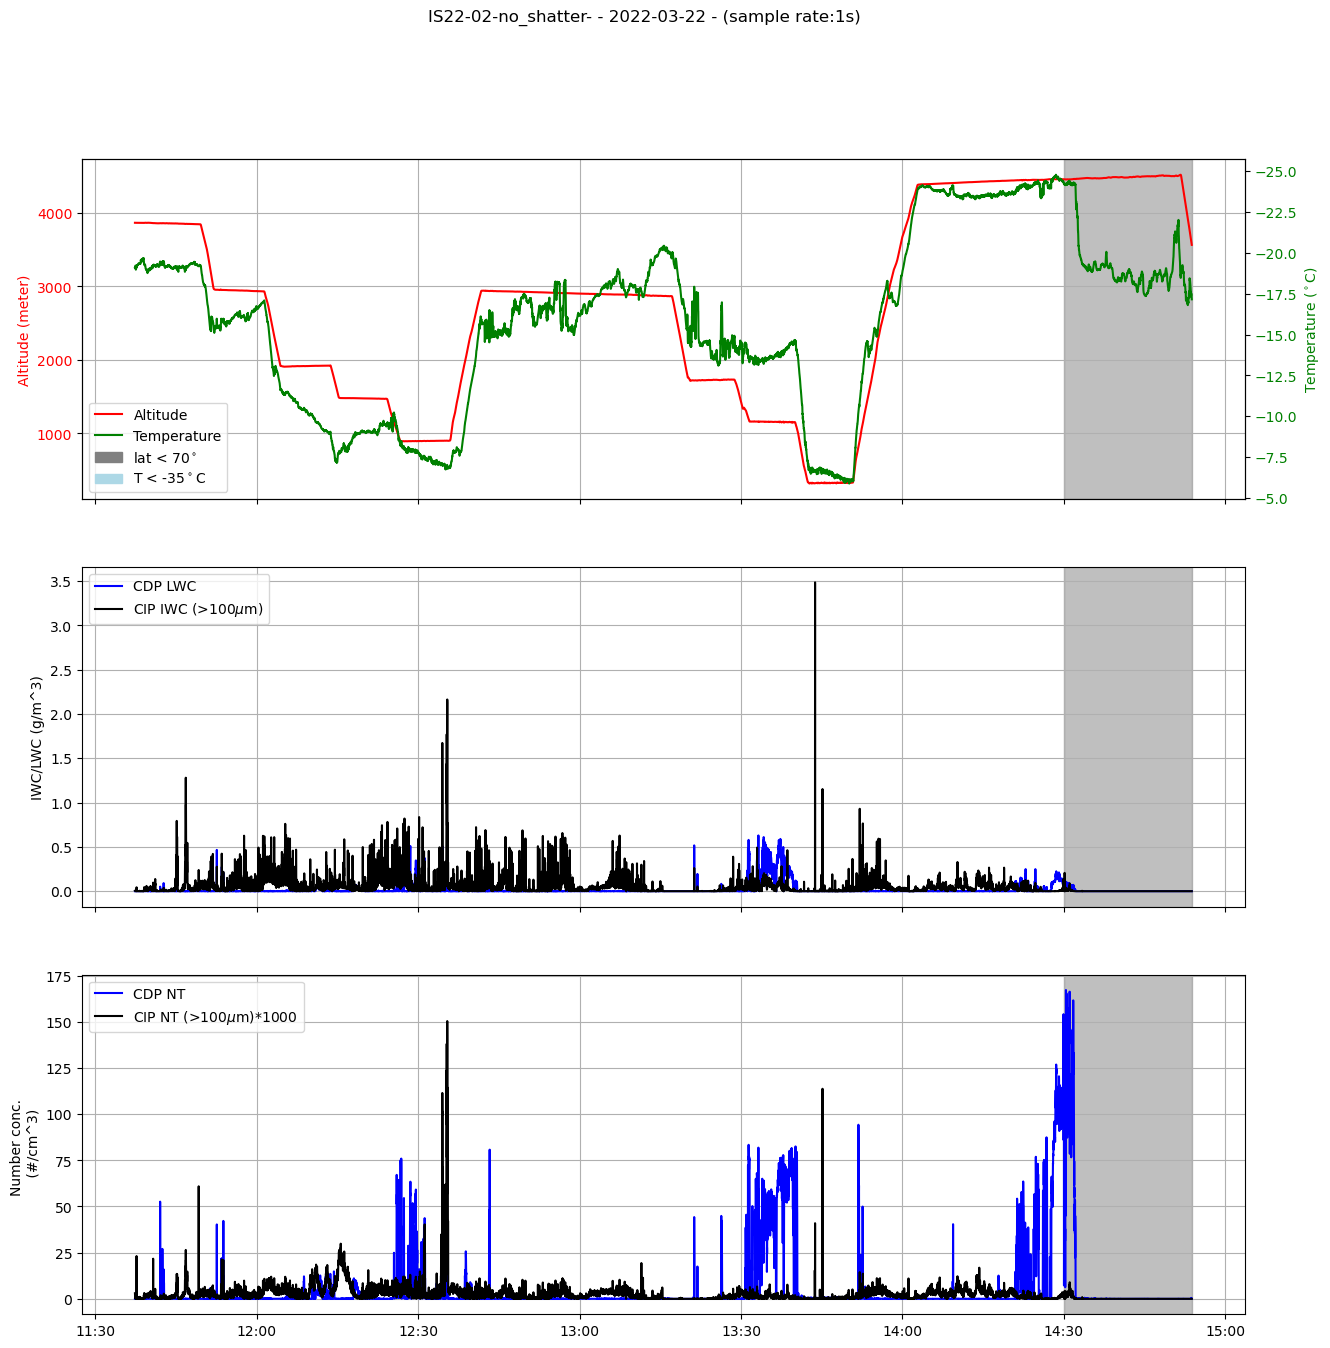

In [9]:
# ---- Plot coordinates -----

# --- Set up figure
fig, ax = plt.subplots(3,1, sharex=True,figsize=(15, 15))

fig.suptitle(f'{flight} - {np.datetime64(flight_ds['time'][0].values,'D')} - (sample rate:{sample_rate}s)') # title for all figure: flightid and date

# temperature and altitude plot
ax[0].plot(flight_ds['time'], flight_ds['alt'], c ='r', label='Altitude')
ax[0].set_ylabel('Altitude (meter)', color='r')
ax[0].xaxis.set_major_formatter(formatter) # only show time on x-axis
ax[0].tick_params(axis='y', labelcolor='r')
ax[0].legend()
ax[0].grid(True)

axt=ax[0].twinx() # second axses for temperature
axt.set_ylabel('Temperature ($^\circ$C)', color='g')
axt.plot(flight_ds['time'], flight_ds['T'], c ='g', label='Temperature')
axt.yaxis.set_inverted(True) # temperature axis inverted for readability
axt.tick_params(axis='y', labelcolor='g')

# WC plots
ax[1].plot(flight_ds['time'], flight_ds['LWC corr'], c ='b', label='CDP LWC')
ax[1].plot(flight_ds['time'], flight_ds['IWC'], c ='k', label='CIP IWC (>100$\mu$m)')
ax[1].set_ylabel(f'IWC/LWC ({flight_ds['LWC corr'].attrs['unit']})')
ax[1].legend()
ax[1].grid(True)

# number concentration plots
ax[2].plot(flight_ds['time'], flight_ds['Number Conc corr'], c ='b', label='CDP NT')
ax[2].plot(flight_ds['time'], (flight_ds['NT100']/1000000)*1000, c ='k', label='CIP NT (>100$\mu$m)*1000') # divided by 1000000 go get /cm3
ax[2].set_ylabel(f'Number conc. \n ({flight_ds['Number Conc corr'].attrs['unit']})')
ax[2].legend()
ax[2].grid(True)


# --- Highlight areas where latitude is less than 70 degrees ---
lat = flight_ds['lat'].values
temp = flight_ds['T'].values
time = flight_ds['time'].values

# Loop through latitude to find the spans

for i in range(1, len(temp)):
    if temp[i] < -35 and temp[i-1] >= -35:
        axv_start = time[i-1]  # start of the span
    elif temp[i] >= -35 and temp[i-1] < -35:
        axv_end = time[i]  # end of the last span
        ax[0].axvspan(axv_start, axv_end, color='lightblue', alpha=0.5)
        ax[1].axvspan(axv_start, axv_end, color='lightblue', alpha=0.5)
        ax[2].axvspan(axv_start, axv_end, color='lightblue', alpha=0.5)

# Loop through latitude to find the spans
if lat[0]<70:
    axv_start=time[0]
for i in range(1, len(lat)):
    if lat[i] < 70 and lat[i-1] >= 70:
        axv_start = time[i-1]  # start of the span
    elif lat[i] >= 70 and lat[i-1] < 70:
        axv_end = time[i]  # end of the last span
        ax[0].axvspan(axv_start, axv_end, color='gray', alpha=0.5)
        ax[1].axvspan(axv_start, axv_end, color='gray', alpha=0.5)
        ax[2].axvspan(axv_start, axv_end, color='gray', alpha=0.5)
if lat[-1]<70:
    axv_end = time[-1]  # end of the last span
    ax[0].axvspan(axv_start, axv_end, color='gray', alpha=0.5)
    ax[1].axvspan(axv_start, axv_end, color='gray', alpha=0.5)
    ax[2].axvspan(axv_start, axv_end, color='gray', alpha=0.5)

h1, l1 = ax[0].get_legend_handles_labels()
h2, l2 = axt.get_legend_handles_labels()

legend_elements = [Patch(facecolor='gray', edgecolor='gray',
                         label='lat < 70$^\circ$'),
                   Patch(facecolor='lightblue', edgecolor='lightblue',
                         label='T < -35$^\circ$C')]

ax[0].legend(handles=h1 + h2 + legend_elements)#, loc='center')

plt.savefig(f'Flight_overview_{flight}.png')

In [10]:
# --- check data
#print(flight_ds.time.max())
#print(flight_ds.time.min())
# flight_ds
# ds_i

## More flight information 

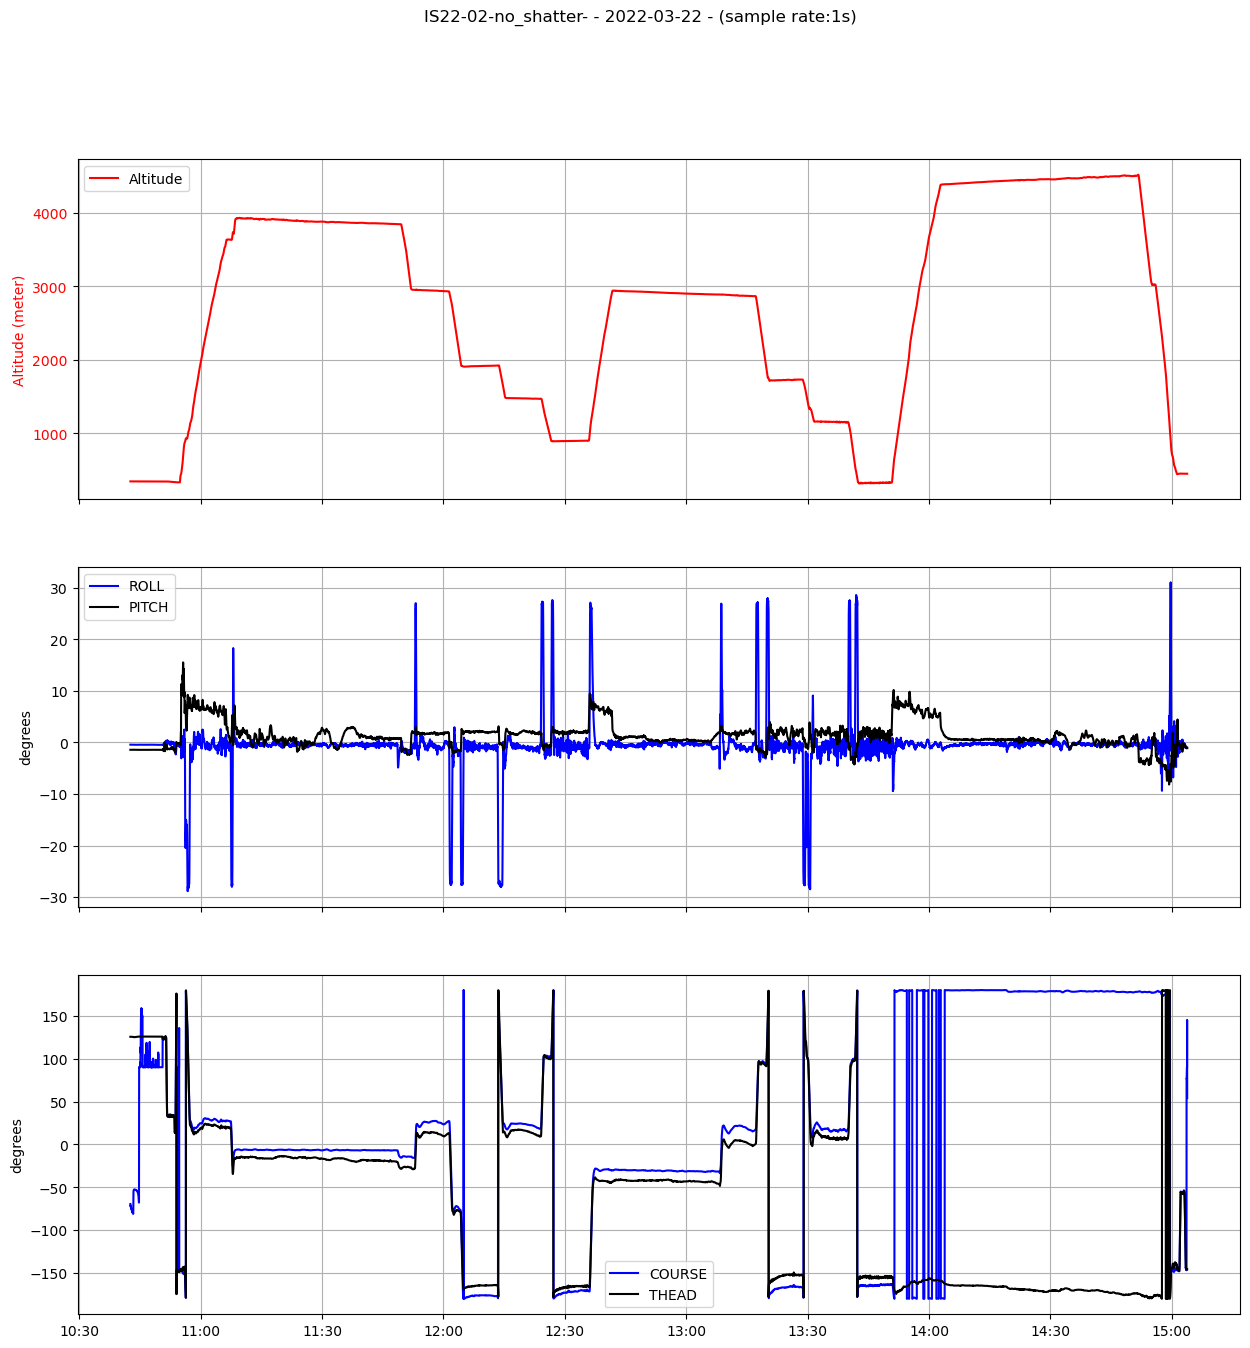

In [13]:
flight_info = xr.open_dataset('/home/ninalar/Documents/MC2/2022-islas/as220007/ISLAS_SAFIRE-ATR42_CORE_NAV_1HZ_20220322_as220007_L1_V1.nc')
flight_info

# --- Set up figure
fig, ax = plt.subplots(3,1, sharex=True,figsize=(15, 15))

fig.suptitle(f'{flight} - {np.datetime64(flight_ds['time'][0].values,'D')} - (sample rate:{sample_rate}s)') # title for all figure: flightid and date

# altitude plot
ax[0].plot(flight_info['time'], flight_info['ALTITUDE'], c ='r', label='Altitude')
ax[0].set_ylabel('Altitude (meter)', color='r')
ax[0].xaxis.set_major_formatter(formatter) # only show time on x-axis
ax[0].tick_params(axis='y', labelcolor='r')
ax[0].legend()
ax[0].grid(True)


# roll and pitch plots
ax[1].plot(flight_info['time'], flight_info['ROLL'], c ='b', label='ROLL')
ax[1].plot(flight_info['time'], flight_info['PITCH'], c ='k', label='PITCH')
ax[1].set_ylabel('degrees')
ax[1].legend(),
ax[1].grid(True)

# number concentration plots
ax[2].plot(flight_info['time'], flight_info['COURSE'], c ='b', label='COURSE')
ax[2].plot(flight_info['time'], flight_info['THEAD'], c ='k', label='THEAD') 
ax[2].set_ylabel('degrees')
ax[2].legend()
ax[2].grid(True)

NameError: name 'ds_i' is not defined

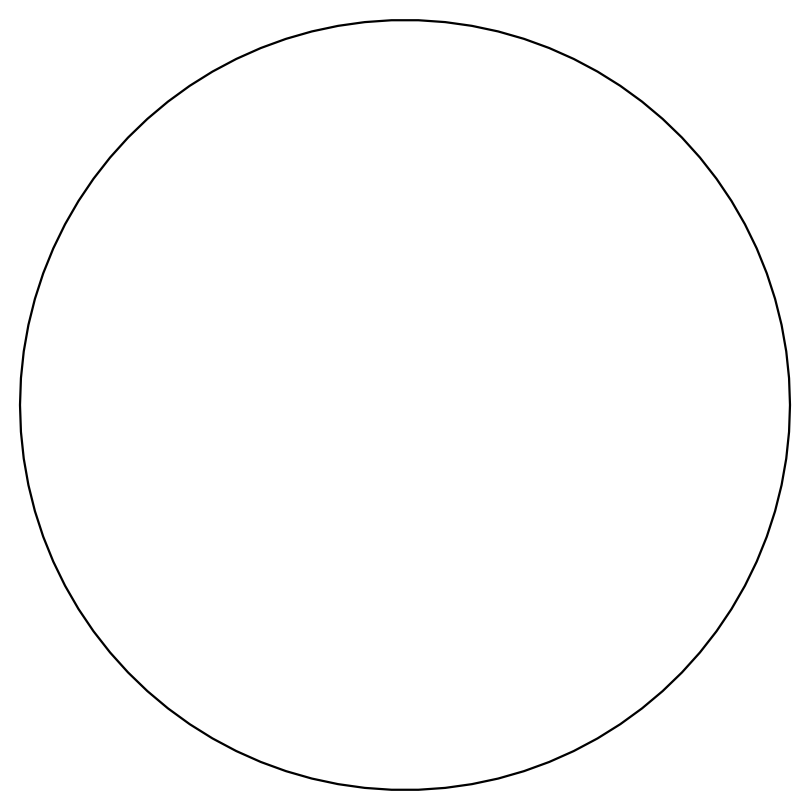

In [52]:
# plot flight path on top of satellite data (Satellite MODIS)

stepfig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.NorthPolarStereo()}, figsize=(10, 5), dpi=200)

#stepfig.suptitle(f'{flight} - {np.datetime64(flight_ds['time'][0].values,'D')}: TWC over flightpath') # title for all figure: flightid and date
#stepfig.suptitle(f'TWC from one flight({flight}) \n over MODIS image') # title for all figure: flightid and date

cb = ax.pcolormesh(ds_i.lon, ds_i.lat, ds_i.radiance.isel(band=0), transform=ccrs.PlateCarree(), cmap="gray", vmax=150)

# Mask TWC data for setting colors
twc_values = flight_ds['TWC'].values
colors = np.where(twc_values > 0, twc_values, np.nan)  # Use twc_values for positive, NaN for zeros

# Plot TWC using colormap, zero values will be ignored
ftwc = ax.scatter(flight_ds['lon'], flight_ds['lat'], transform = ccrs.PlateCarree(), marker='.', c=colors, cmap='Blues_r')

# Plot zero TWC separately in black
#ftwc_zero = ax.scatter(flight_ds['lon'].where(flight_ds['TWC'] == 0), flight_ds['lat'].where(flight_ds['TWC'] == 0),
 #                      transform = ccrs.PlateCarree(), marker='.', c='w', label='TWC=0')

#fl = ax.scatter(flight_ds['lon'], flight_ds['lat'], transform = ccrs.PlateCarree(), marker = '.', c = flight_ds['TWC'],cmap='gist_heat_r')

#Plot Kiruna on map
ax.plot(lon_kir, lat_kir, marker='o', color='tab:red', transform=ccrs.PlateCarree())
#Add text "Kiruna" at the plotted point
offset_lon = 0.7  # adjust the horizontal offset
offset_lat = -0.7  # adjust the vertical offset
ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=ccrs.PlateCarree(), ha='right', va='bottom')

#plt.colorbar(cb, label="band 1 [W m-2 micron-1 sr-1]")
plt.colorbar(ftwc, label = f'TWC ({flight_ds['TWC'].attrs['unit']})')
ax.set_extent([all_lon_min, all_lon_max, lat_min, all_lat_max], crs=ccrs.PlateCarree())  # limit area
ax.gridlines()
ax.coastlines()
#ax.legend(loc='upper right')

#second band
#cb = ax[1].pcolormesh(ds_i.lon, ds_i.lat, ds_i.radiance.isel(band=1), transform=ccrs.PlateCarree(), cmap="gray", vmax=150)
#fl = ax[1].plot(flight_ds['lon'], flight_ds['lat'], transform = ccrs.PlateCarree(), c='r', label=f'Flight {flight}')

#plt.colorbar(cb, label="band 2 [W m-2 micron-1 sr-1]")
#ax[1].set_extent([lon_min+2, lon_max-2, lat_min+2, lat_max-2], crs=ccrs.PlateCarree())  # limit area
#ax[1].gridlines()
#ax[1].coastlines()
plt.tight_layout()
#plt.show()
plt.savefig(f'TWC_sat_forPoster{flight}.png')

KeyError: "No variable named 'TWC'. Did you mean one of ('LWC', 'IWC')?"

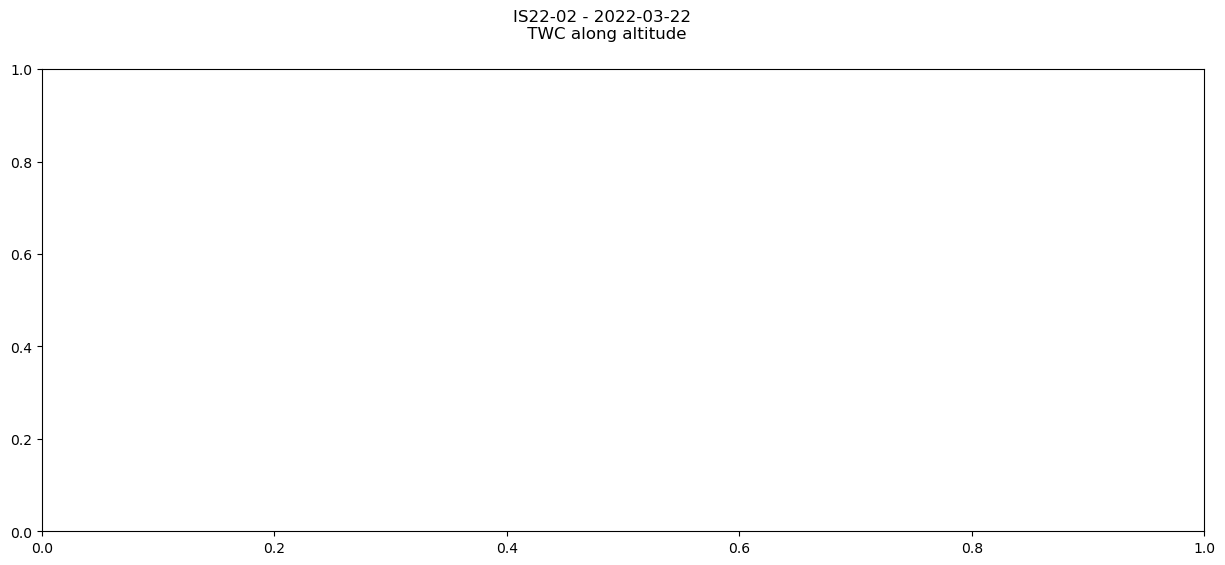

In [9]:
# ---- Plot coordinates -----

# --- Set up figure
fig, ax = plt.subplots(figsize=(15, 6))

fig.suptitle(f'{flight} - {np.datetime64(flight_ds['time'][0].values,'D')} \n TWC along altitude') # title for all figure: flightid and date

# Mask TWC data for setting colors
twc_values = flight_ds['TWC'].values
colors = np.where(twc_values > 0, twc_values, np.nan)  # Use twc_values for positive, NaN for zeros

# Plot TWC using colormap, zero values will be ignored
ftwc = ax.scatter(flight_ds['time'], flight_ds['alt'], marker='.', c=colors, cmap='Blues_r', label='TWC')

# Plot zero TWC separately in black
ftwc_zero = ax.scatter(flight_ds['time'].where(flight_ds['TWC'] == 0), flight_ds['alt'].where(flight_ds['TWC'] == 0), marker='.', c='k',alpha=0.1, label='TWC = 0')


ax.set_ylabel('Altitude (meter)')
ax.xaxis.set_major_formatter(formatter) # only show time on x-axis
ax.legend()

plt.colorbar(ftwc, label = f'TWC ({flight_ds['TWC'].attrs['unit']})')
plt.grid(True)


#plt.savefig(f'TWC_altitude_{flight}.png')

In [10]:
flight_ds

<xarray.Dataset> Size: 26MB
Dimensions:                 (time: 11787, Vector64: 64, Vector40: 40,
                             CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 94kB 2022-03-22T11:37:21 .....
    lat                     (time) float32 47kB dask.array<chunksize=(11787,), meta=np.ndarray>
    lon                     (time) float32 47kB dask.array<chunksize=(11787,), meta=np.ndarray>
    alt                     (time) float32 47kB dask.array<chunksize=(11787,), meta=np.ndarray>
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    islasid                 <U7 28B ...
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/73)
    base_time               datetime64[ns] 8B ...
    utc_time                (time) float64 94kB dask.array<chunksize=(11787,), meta=np.ndarray>
    TAS                     (time) float32 47kB dask.array<chunksize=(11787,), meta=np.ndarray>
    MIDBINS                 (Vector64) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    ACTIVETIME              (time) float32 47kB dask.array<chunksize=(11787,), meta=np.ndarray>
    SA                      (Vector64) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    ...                      ...
    TAS reduce              (time) float32 47kB dask.array<chunksize=(11787,), meta=np.ndarray>
    TAS correction factor   (time) float64 94kB dask.array<chunksize=(11787,), meta=np.ndarray>
    Number Conc corr        (time) float64 94kB dask.array<chunksize=(11787,), meta=np.ndarray>
    LWC corr                (time) float64 94kB dask.array<chunksize=(11787,), meta=np.ndarray>
    SV                      (time) float32 47kB dask.array<chunksize=(11787,), meta=np.ndarray>
    SV_CDP                  (time) float32 47kB dask.array<chunksize=(11787,), meta=np.ndarray>
Attributes:
    safireid:                 as220007
    islasid:                  IS22-02
    parent files:             ['CIP_update_1s_IS22-02.nc', 'CDP_updated_IS22-...
    date_modified:            2025-05-26
    Joint sample rate (sek):  1.0

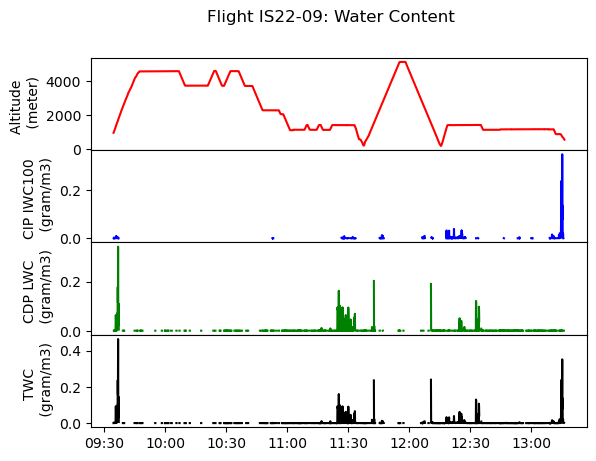

In [ ]:
# --- Plot information about the Water content parameters over the flight 
fig = plt.figure()
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle(f'Flight {flight}: Water Content')

axs[0].plot(flight_ds['time'], flight_ds['alt'], c ='r')
axs[0].set_ylabel('Altitude \n (meter)')


axs[1].plot(flight_ds['time'].where(flight_ds['IWC100']> 0),flight_ds['IWC100'].where(flight_ds['IWC100'] > 0), c='b')
axs[1].set_ylabel('CIP IWC100 \n (gram/m3)')

axs[2].plot(flight_ds['time'].where(flight_ds['LWC']> 0),flight_ds['LWC'].where(flight_ds['LWC']> 0), c='g')
axs[2].set_ylabel('CDP LWC \n (gram/m3)')

axs[3].plot(flight_ds['time'].where(flight_ds['TWC']> 0),flight_ds['TWC'].where(flight_ds['TWC']> 0), c='k')
axs[3].set_ylabel('TWC \n (gram/m3)')

axs[0].set_xlabel('Time')
axs[0].xaxis.set_major_formatter(formatter)


# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()


plt.savefig(f'{flight}_WC_overview.png')

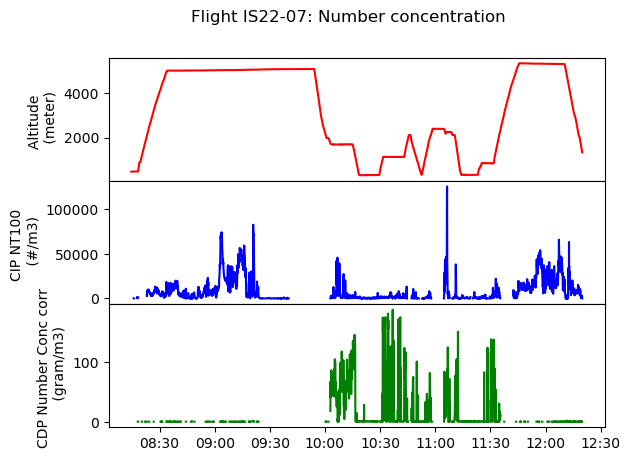

In [ ]:
# --- Plot information about the number concentration parameters over the flight 
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle(f'Flight {flight}: Number concentration')

axs[0].plot(flight_ds['time'], flight_ds['alt'], c ='r')
axs[0].set_ylabel('Altitude \n (meter)')
#NT100 Number Conc corr

axs[1].plot(flight_ds['time'].where(flight_ds['NT100']> 0),flight_ds['NT100'].where(flight_ds['NT100'] > 0), c='b')
axs[1].set_ylabel('CIP NT100 \n (#/m3)')

axs[2].plot(flight_ds['time'].where(flight_ds['Number Conc corr']> 0),flight_ds['Number Conc corr'].where(flight_ds['Number Conc corr']> 0), c='g')
axs[2].set_ylabel('CDP Number Conc corr \n (gram/m3)')

#axs[3].plot(flight_ds['time'].where(flight_ds['TWC']> 0),flight_ds['TWC'].where(flight_ds['TWC']> 0), c='k')
#axs[3].set_ylabel('TWC \n (gram/m3)')

axs[0].set_xlabel('Time')
axs[0].xaxis.set_major_formatter(formatter)


# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()


plt.savefig(f'{flight}_NT_overview.png')

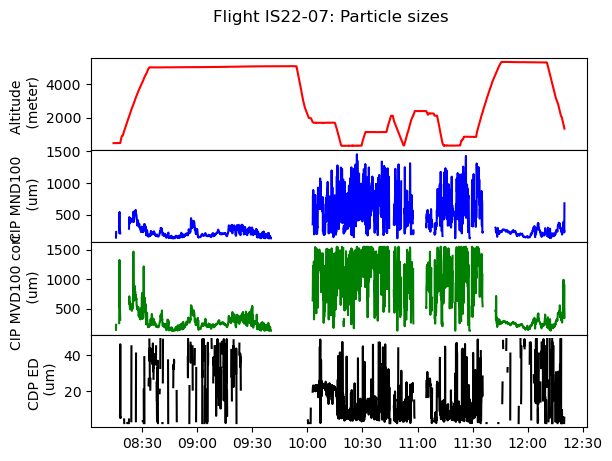

In [ ]:
# --- Plot information about the particle size parameters over the flight 
fig = plt.figure()
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle(f'Flight {flight}: Particle sizes')

axs[0].plot(flight_ds['time'], flight_ds['alt'], c ='r')
axs[0].set_ylabel('Altitude \n (meter)')
#MND100 MVD100 ED

axs[1].plot(flight_ds['time'].where(flight_ds['MND100']> 0),flight_ds['MND100'].where(flight_ds['MND100'] > 0), c='b')
axs[1].set_ylabel('CIP MND100 \n (um)')

axs[2].plot(flight_ds['time'].where(flight_ds['MVD100']> 0),flight_ds['MVD100'].where(flight_ds['MVD100']> 0), c='g')
axs[2].set_ylabel('CIP MVD100 corr \n (um)')

axs[3].plot(flight_ds['time'].where(flight_ds['ED']> 0),flight_ds['ED'].where(flight_ds['ED']> 0), c='k')
axs[3].set_ylabel('CDP ED \n (um)')

axs[0].set_xlabel('Time')
axs[0].xaxis.set_major_formatter(formatter)


# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()


plt.savefig(f'{flight}_PS_overview.png')

In [ ]:
flight_ds

<xarray.Dataset> Size: 7MB
Dimensions:                 (time: 2945, Vector64: 64, Vector40: 40, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 24kB 2022-03-29T08:14:36 .....
    lat                     (time) float32 12kB dask.array<chunksize=(2945,), meta=np.ndarray>
    lon                     (time) float32 12kB dask.array<chunksize=(2945,), meta=np.ndarray>
    alt                     (time) float32 12kB dask.array<chunksize=(2945,), meta=np.ndarray>
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/75)
    base_time               datetime64[ns] 8B ...
    utc_time                (time) float64 24kB dask.array<chunksize=(2945,), meta=np.ndarray>
    TAS                     (time) float32 12kB dask.array<chunksize=(2945,), meta=np.ndarray>
    MIDBINS                 (Vector64) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    ACTIVETIME              (time) float32 12kB dask.array<chunksize=(2945,), meta=np.ndarray>
    SA                      (Vector64) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    ...                      ...
    SLF_twc                 (time) float64 24kB dask.array<chunksize=(2945,), meta=np.ndarray>
    surface_cond            (time) <U4 47kB dask.array<chunksize=(2945,), meta=np.ndarray>
    in_cloud_lwc            (time) bool 3kB dask.array<chunksize=(2945,), meta=np.ndarray>
    in_cloud_twc            (time) bool 3kB dask.array<chunksize=(2945,), meta=np.ndarray>
    in_cloud                (time) bool 3kB dask.array<chunksize=(2945,), meta=np.ndarray>
    Relevance               (time) <U12 141kB dask.array<chunksize=(2945,), meta=np.ndarray>
Attributes:
    safireid:                   as220011
    islasid:                    IS22-07
    parent files:               ['CIP_update_5s_IS22-07.nc', 'CDP_updated_IS2...
    date_modified:              2025-03-20
    Joint dataset sample rate:  5.0
    CDP sample area:            0.269
    CDP sample area unit:       mm²
    incloud_thres:              0.01

## Marg plot for the full flight and for the mixed phase clouds

NB! not opdated for the new xarray flight_ds!!!




In [ ]:
%%skip
## SINGLE MARGPLOT Testing!!!
def slf_marg_plot(df, title, obs_cat,filestr = ""):
    import matplotlib.gridspec as gridspec

    # preparing for histogram and 2d histogram
    temperature = df['Temperature (Celsius)'].values
    slf = df['SLF'].values

    # Define bins and range
    x_bins = 20
    y_bins = 20
    x_range = [-40, 0]
    y_range = [0, 100]

    # Compute the 2D histogram with numpy histogram2d to get the normalization correct
    hist, xedges, yedges = np.histogram2d(temperature, slf, 
                                       bins=[x_bins, y_bins], 
                                       range=[x_range, y_range], 
                                       density=True)
    
    fig = plt.figure(figsize=(12,8))

    plt.rcParams['font.size'] = 18
    
    gs = gridspec.GridSpec(3, 4, wspace = 0, hspace = 0)
    ax_main = plt.subplot(gs[1:3, 1:3])
    ax_xDist = plt.subplot(gs[0, 1:3],sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 3],sharey=ax_main)
    ax_cb = plt.subplot(gs[1:3,0],sharey=ax_main)
    ax_cb.axis('off')
    ax_text = plt.subplot(gs[0,3])
    ax_text.axis('off')
    plots.letter_annotation(ax_text, 0.3, 0.3, f'tot. # of \n{obs_cat} obs.: \n{len(df)}')
        
    hh = ax_main.imshow(hist.T, origin='lower', cmap=plt.cm.Blues, 
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                     aspect='auto')
    ax_main.set_ylabel('SLF %')
    ax_main.set_xlabel('Temperature ($\mathregular{\degree C}$)')
    
    
    ax_xDist.hist(temperature,bins=x_bins, align='left', density = True) # Density = True means normalized
    ax_xDist.set(ylabel='norm. count')
    ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    old_ticks=ax_xDist.get_yticks()
    new_ticks=[x for x in old_ticks if x!=0]
    ax_xDist.set_yticks(new_ticks)
    
    ax_yDist.hist(slf,bins=y_bins,orientation='horizontal', density = True)
    ax_yDist.set(xlabel='norm. count')
    ax_yDist.yaxis.tick_right()
    old_ticks=ax_yDist.get_xticks() # removing 0 from ticks (improves readability)
    new_ticks=[x for x in old_ticks if x!=0]
    ax_yDist.set_xticks(new_ticks)
    
    cbar = plt.colorbar(hh, ax = ax_cb, location='left', orientation='vertical')
    cbar.set_label('norm. # of SLFs per Temp', rotation=90)
    
    fig.suptitle(title, fontsize = 'large')
    plt.show

    if filestr != '':
        plt.savefig(filestr)
    
    return(fig)

df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['Relevance']=='Lower clouds, relevant')]
mp_plot = slf_marg_plot(df, f'SLF distribution for mixed phase clouds during flight {flight}', 'mixed-phase', f'mixedphase{flight}.png')
#all_plot = slf_marg_plot(flight_sel_df, f'SLF for all clouds during flight {flight}', f'allclouds{flight}.png')

In [ ]:
# OLD STUFF!! plot the 100 um variables against altitude and time


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')


fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10,10))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
axs[0].set_title(f'CIP microphysics parameters (Particles Larger than 100um in Diameter) for flight {cip_updated_xds.attrs['islasid']}')

# Plot each graph, and manually set the y tick values
axs[0].plot(cip_updated_xds.time, cip_updated_xds.ALTITUDE, c='k')
axs[0].set_ylabel(f'Altitude \n ({cip_updated_xds.ALTITUDE.units})')

axs2 = axs[0].twinx()
axs2.plot(cip_updated_xds.time, cip_updated_xds.NT100, c= 'r')
axs2.set_ylabel(f'Number \n concentration \n ({cip_updated_xds.NT100.units})', c='r')
axs2.tick_params(axis='y', colors = 'r')

axs[1].plot(cip_updated_xds.time, cip_updated_xds.IWC100)
axs[1].set_ylabel(f'IWC100 \n ({cip_updated_xds.IWC100.units})')

axs[2].plot(cip_updated_xds.time, cip_updated_xds.MND100, label = 'MND100')
axs[2].plot(cip_updated_xds.time, cip_updated_xds.MVD100, label = 'MVD100', alpha = 0.3)
axs[2].set_ylabel(f'Particle diameter \n ({cip_updated_xds.MND100.units})')
axs[2].legend()

axs[3].plot(cip_updated_xds.time, cip_updated_xds.AREA100)
axs[3].set_ylabel(f'Projected area \n ({cip_updated_xds.AREA100.units})')

axs[0].xaxis.set_major_formatter(formatter) # only show time on x-axis

plt.savefig('100microphysics_IS22-01.png')
plt.show()

In [ ]:
%%skip
# function to create the multifigures.

# Set the default font size for all elements
plt.rcParams.update({'font.size': 10})  # Set this to whatever size you want, e.g., 10


def slf_marg_plot_grid(df, title, row_cat="", col_cat="", filestr=""):
    # Be sure to only use "in-cloud" values from the dataframe:
    df = df[df['incloud']==True]
    
    # Remove NaN values from the row_cat and col_cat columns before getting unique values
    unique_row_cats = df[row_cat].dropna().unique() if row_cat else [""]
    unique_col_cats = df[col_cat].dropna().unique() if col_cat else [""]

    nrows = len(unique_row_cats)
    ncols = len(unique_col_cats)
    fig = plt.figure(figsize=(6 * ncols, 4 * nrows))
    gs = gridspec.GridSpec(6 * nrows, 5 * ncols, figure=fig, wspace=0, hspace=0)
    
    def slf_marg_plot_intern(df, title, i, j):
        ax_main = plt.subplot(gs.new_subplotspec((1 + i * 6, 1 + j * 5), rowspan=2, colspan=2))
        ax_xDist = plt.subplot(gs.new_subplotspec((i * 6, 1 + j * 5), colspan=2), sharex=ax_main)
        ax_yDist = plt.subplot(gs.new_subplotspec((1 + i * 6, 3 + j * 5), rowspan=2), sharey=ax_main)
        ax_cb = plt.subplot(gs.new_subplotspec((1 + i*6, j * 5), rowspan=2), sharey=ax_main)
        ax_cb.axis('off')
        ax_text = plt.subplot(gs.new_subplotspec((i*6, 3+j*5)))
        ax_text.axis('off')

        # Annotate the free area in the right-hand corner with text
        ax_text.annotate(
            f'# of \n obs.: \n{len(df)}', 
            xy=(1, 1), 
            xycoords='axes fraction', 
            ha='right', 
            va='top', 
            fontsize='medium'
        )

        # preparing for histogram and 2d histogram
        temperature = df['Temperature (Celsius)'].values
        slf = df['SLF'].values

        # Define bins and range
        x_bins = 20
        y_bins = 20
        x_range = [-40, 0]
        y_range = [0, 100]

        # Compute the 2D histogram with numpy histogram2d to get the normalization correct
        hist, xedges, yedges = np.histogram2d(temperature, slf, 
                                       bins=[x_bins, y_bins], 
                                       range=[x_range, y_range], 
                                       density=True)
        hh = ax_main.imshow(hist.T, origin='lower', cmap=plt.cm.Blues, 
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                     aspect='auto')
        
        ax_main.set_ylabel('SLF %')
        ax_main.set_xlabel('Temperature ($\mathregular{\degree C}$)')

        ax_xDist.hist(temperature, bins=x_bins, range=x_range, align='mid', density=True)
        ax_xDist.set(ylabel='norm. \n count')
        ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        old_ticks = ax_xDist.get_yticks()
        new_ticks = [x for x in old_ticks if x != 0]
        ax_xDist.set_yticks(new_ticks)

        ax_yDist.hist(slf, bins=y_bins, orientation='horizontal', density=True)
        ax_yDist.set(xlabel='norm. \n count')
        ax_yDist.yaxis.tick_right()
        old_ticks = ax_yDist.get_xticks()
        new_ticks = [x for x in old_ticks if x != 0]
        ax_yDist.set_xticks(new_ticks)

        cbar = plt.colorbar(hh, ax=ax_cb, location='left', orientation='vertical')
        cbar.set_label('norm. # of SLFs per Temp', rotation=90)

        #ax_main.set_title(title, fontsize='medium', pad = 60)
        # Only set the column header for the top row plots
        if i == 0 and col_cat:
            ax_main.set_title(f"{unique_col_cats[j]}", fontsize='large', pad=60)
        
        # Only set the row header for the leftmost column plots
        if j == 0 and row_cat:
            ax_main.annotate(f"{unique_row_cats[i]}", xy=(-1.2, 0.5), xycoords='axes fraction',
                             ha='center', va='center', rotation=90, fontsize='large')


    for i, row_value in enumerate(unique_row_cats):
        for j, col_value in enumerate(unique_col_cats):
            if row_cat and col_cat:
                filtered_df = df[(df[row_cat] == row_value) & (df[col_cat] == col_value)]
                plot_title = f"{row_value}, {col_cat}={col_value}"
            elif row_cat:
                filtered_df = df[df[row_cat] == row_value]
                plot_title = f"{row_value}"
            elif col_cat:
                filtered_df = df[df[col_cat] == col_value]
                plot_title = f"{col_value}"
            else:
                filtered_df = df
                plot_title = title

            slf_marg_plot_intern(filtered_df, plot_title, i, j)

    
    fig.suptitle(title, fontsize='large')

    if filestr:
        plt.savefig(filestr)
    
   # plt.show()

    return fig

# All clouds in ISLAS:
#slf_marg_plot_grid(microphy_df, 'SLF distribution divided by \n surface conditions and cloud position \n ISLAS - all clouds',col_cat='surface_cond', row_cat='Cloud_pos', filestr='SLF_dist_ISLAS_all.png')

# Mixed phase in ISLAS
mp_all_df = microphy_df[microphy_df['Relevance']=='Lower clouds, relevant']
slf_marg_plot_grid(mp_all_df, 'SLF distribution divided by \n surface conditions and cloud position \n ISLAS - mixed phase clouds',col_cat='surface_cond', row_cat='Cloud_pos', filestr='SLF_dist_ISLAS_mp.png')

# Only sea-ice flights
#mp_si_flights_df = microphy_df[(microphy_df['Relevance']=='Lower clouds, relevant') & (microphy_df['flightid'].isin(['IS22-10','IS22-11']))]
#slf_marg_plot_grid(mp_si_flights_df, 'SLF distribution divided by \n surface conditions and cloud position \n IS22-10 and IS22-11 - mixed phase clouds', col_cat='surface_cond', row_cat='Cloud_pos', filestr='SLF_dist_is22-10-11.png')



## Number concentration and size distributions

In [ ]:
# Get the normalized values for plotting (from functions in numb_conc)
cip_part_norm = numb_conc.cip_mean_norm_Nt(flight_ds)
cdp_part_norm = numb_conc.cdp_mean_norm_Nt(flight_ds)


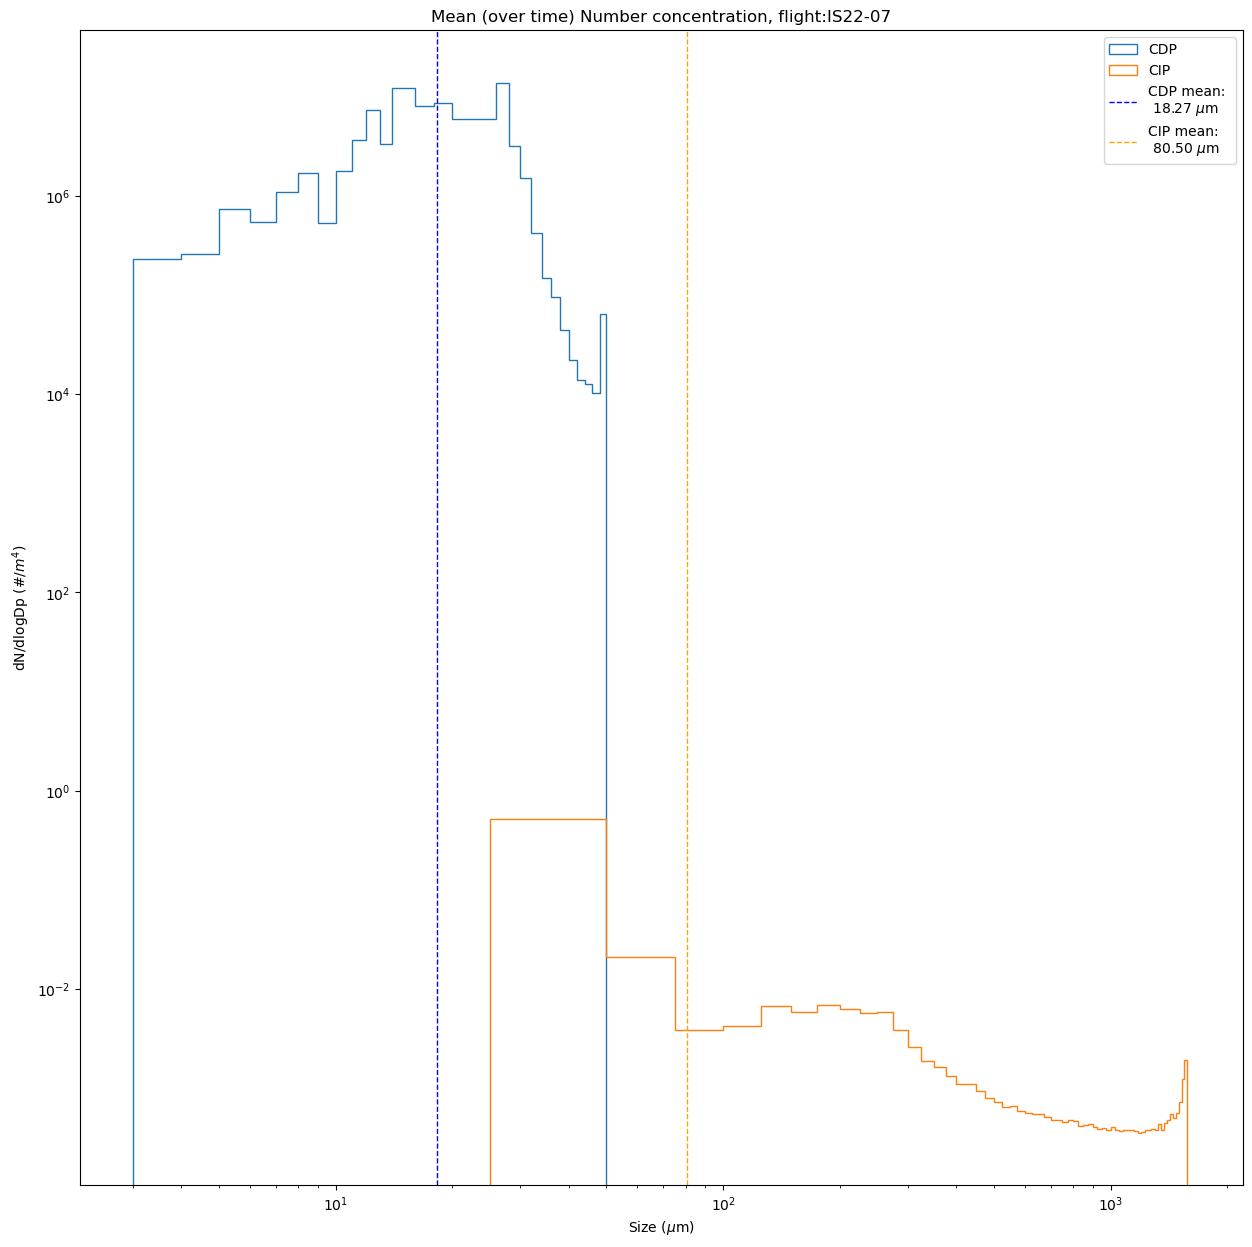

In [ ]:
# -- Number concentration hist plot: Single plot, all values from single flight
# -- Preparations

# first step: make a boxplot based on the new data for the cdp
fig, ax = plt.subplots(figsize = (15,15))

ax.hist(flight_ds['Size'].values, weights = cdp_part_norm.values, bins=flight_ds['Size'].values, label = "CDP", histtype='step')
ax.hist(flight_ds['MIDBINS'].values, weights = cip_part_norm.values, bins=flight_ds['MIDBINS'].values, label = "CIP", histtype='step')

# calculate mean from the histogram data
prod_val_count_cdp = flight_ds['Size'].values*cdp_part_norm.values
tot_sum = prod_val_count_cdp.sum()
counts= cdp_part_norm.values
count_sum = counts.sum()
mean_size_cdp = tot_sum/count_sum
ax.axvline(mean_size_cdp, color='blue', linestyle='dashed', linewidth=1, label=f'CDP mean: \n {mean_size_cdp:.2f} $\mu$m')

prod_val_count_cip = cip_part_norm.values*flight_ds['MIDBINS'].values
tot_sum = prod_val_count_cip.sum()
count_sum = cip_part_norm.values.sum()
mean_size_cip = tot_sum/count_sum
ax.axvline(mean_size_cip, color='orange', linestyle='dashed', linewidth=1, label=f'CIP mean: \n {mean_size_cip:.2f} $\mu$m')
    
plt.yscale('log')
plt.xscale('log')

ax.set_ylabel('dN/dlogDp (#/$m^4$)')
ax.set_xlabel('Size ($\mu$m)')
ax.set_title(f'Mean (over time) Number concentration, flight:{flight}')
ax.legend()

plt.show()

# separate out the different groups of data:
# - Northern marine
# -- Upper layer/top of clouds -- defined as the x upper altitude bins?
# -- Mid layer/ bulk of clouds
# -- Lower layer/ base of cloud + precip
# - Southern marine
# -- Upper layer/top of clouds
# -- Mid layer/ bulk of clouds
# -- Lower layer/ base of cloud + precip